In [ ]:
# Предобработка данных и логистическая регрессия

В задании вы познакомитесь с основными техниками предобработки данных и примените их для обучения модели логистической регрессии. Ответ потребуется загрузить в соответствующую форму в виде 6 текстовых файлов.

Для выполнения задания требуется Python версии 2.7, а также актуальные версии библиотек:
- NumPy: 1.10.4 и выше
- Pandas: 0.17.1 и выше
- Scikit-learn: 0.17 и выше

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

## Данные

Задача: по 38 признакам, связанных с заявкой на грант (область исследований учёных, информация по их академическому бэкграунду, размер гранта, область, в которой он выдаётся) предсказать, будет ли заявка принята. Датасет включает в себя информацию по 6000 заявкам, которые были поданы в университете Мельбурна с 2004 по 2008 год.

Полную версию данных с большим количеством признаков можно найти на https://www.kaggle.com/c/unimelb.

In [2]:
data = pd.read_csv('data.csv')
data.shape
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


Выделим из датасета целевую переменную Grant.Status и обозначим её за y.
Теперь X обозначает обучающую выборку, y — ответы на ней.

In [3]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

## Логистическая регрессия

После осознания того, какую именно задачу требуется решить на этих данных, следующим шагом при реальном анализе был бы подбор подходящего метода. В данном задании выбор метода было произведён за вас — это логистическая регрессия. Давайте вспомним в общих чертах используемую модель.

Логистическая регрессия предсказывает вероятности принадлежности объекта к каждому классу. Сумма ответов логистической регрессии на одном объекте для всех классов равна единице.

$$ \sum_{k=1}^K \pi_{ik} = 1, \quad \pi_k \equiv P\,(y_i = k \mid x_i, w, b), $$

где:
- $\pi_{ik}$ — вероятность принадлежности объекта $x_i$ из выборки $X$ к классу $k$,
- $w, b$ — параметры алгоритма, которые настраиваются в процессе обучения.

Из этого свойства модели в случае бинарной классификации требуется вычислить лишь вероятность принадлежности объекта к одному из классов (вторая вычисляется из условия нормировки вероятностей). Эта вероятность вычисляется, используя логистическую функцию:

$$ P\,(y_i = 1 \mid x_i, w, b) = \frac{1}{1 + \exp(-w^T x_i-b)} $$

Параметры $w$ и $b$ находятся как решения оптимизационной задачи, например, с $L_2$-регуляризацией:

$$ Q(X, y, w, b) = \frac{1}{2} w^T w + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b}, $$

или $L_1$-регуляризацией:

$$ Q(X, y, w, b) = \sum_{d=1}^D |w_d| + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b}.$$

$C$ — гиперпараметр модели, который регулирует то, насколько сильно мы позволяем модели подстраиваться под данные (обозначения немного отличаются от стандартных, которые мы использовали в лекциях, но так уж всё устроено в sklearn).

## Предобработка 

Для применения к данным логистической регрессии нужно, чтобы:
- все $X$ были числовыми,
- в матрице $X$ не было пропусков.

Поэтому базовым этапом в предобработке любых данных для логистической регрессии будет преобразование категориальных признаков и обработка пропущенных значений.

In [4]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


Видно, что в датасете есть и числовые, и категориальные признаки. Получим списки их названий:

In [5]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))
print categorical_cols

['Country.of.Birth.1', 'SEO.Code.4', 'SEO.Code.5', 'B.1', 'SEO.Code.1', 'SEO.Code.2', 'SEO.Code.3', 'C.1', 'No..of.Years.in.Uni.at.Time.of.Grant.1', 'With.PHD.1', 'Sponsor.Code', 'RFCD.Code.5', 'RFCD.Code.4', 'RFCD.Code.3', 'RFCD.Code.2', 'RFCD.Code.1', 'Home.Language.1', 'A..1', 'Person.ID.1', 'Grant.Category.Code', 'Faculty.No..1', 'Role.1', 'Dept.No..1', 'Contract.Value.Band...see.note.A', 'A.1']


Также в нём присутствуют пропущенные значения. Простым решением будет исключение всех объектов, у которых пропущено значение хотя бы одного признака. Это делается так:

In [6]:
data.dropna().shape

(213, 39)

Видно, что тогда мы выбросим почти все данные, это не очень хорошо. Попробуем ещё несколько способов обработки пропусков.

Для вещественных признаков:
- заменить на 0 (данный признак давать вклад в предсказание для данного объекта не будет),
- заменить на среднее (каждый пропущенный признак будет давать такой же вклад, как и среднее значение признака).

Для категориальных:
- интерпретировать пропущенное значение как ещё одну категорию (это самый естественный способ, так как в случае категорий у нас есть уникальная возможность не потерять информацию о наличии пропущенных значений; обратите внимание, что в случае вещественных признаков данная информация неизбежно теряется).

##  Задание 0. Обработка пропусков
1. Заполните пропущенные вещественные значения в X нулями и средними по столбцам, назовите полученные датафреймы X_real_zeros и X_real_mean соответственно. Для подсчёта средних используйте приведённую ниже функцию calculate_means. На вход она принимает вещественные признаки из исходного датафрейма.
2. Все категориальные признаки в X преобразуйте в строки, пропущенные значения замените какой-нибудь строкой, не встречающейся среди значений признаков (закодируйте их строкой 'NA'). Полученный датафрейм назовите X_cat.

In [7]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

# place your code here
X_numeric = X[numeric_cols]
#print X_numeric[8:10][X_numeric.columns[-3:]]
means = calculate_means(X_numeric)
#print means
X_real_zeros = X_numeric.fillna(0)
X_real_mean = X_numeric.fillna(means)
#print X_real_mean[8:10][X_numeric.columns[-3:]]
X_real_zeros.isnull().any()

RFCD.Percentage.1                 False
RFCD.Percentage.2                 False
RFCD.Percentage.3                 False
RFCD.Percentage.4                 False
RFCD.Percentage.5                 False
SEO.Percentage.1                  False
SEO.Percentage.2                  False
SEO.Percentage.3                  False
SEO.Percentage.4                  False
SEO.Percentage.5                  False
Year.of.Birth.1                   False
Number.of.Successful.Grant.1      False
Number.of.Unsuccessful.Grant.1    False
dtype: bool

In [8]:
X_cat = X[categorical_cols]
X_cat = X_cat.fillna('NA')
#X_cat.info()
X_cat = X_cat.astype(str)
#X_cat.info()
X_cat.isnull().any()

Country.of.Birth.1                        False
SEO.Code.4                                False
SEO.Code.5                                False
B.1                                       False
SEO.Code.1                                False
SEO.Code.2                                False
SEO.Code.3                                False
C.1                                       False
No..of.Years.in.Uni.at.Time.of.Grant.1    False
With.PHD.1                                False
Sponsor.Code                              False
RFCD.Code.5                               False
RFCD.Code.4                               False
RFCD.Code.3                               False
RFCD.Code.2                               False
RFCD.Code.1                               False
Home.Language.1                           False
A..1                                      False
Person.ID.1                               False
Grant.Category.Code                       False
Faculty.No..1                           

## Преобразование категориальных признаков

Мы разделили данные на две части: в одной присутствуют только вещественные признаки, в другой — только категориальные. 

Для использования модели регрессии требуется преобразовать категориальные признаки в вещественные. Рассмотрим основной способ преоборазования категориальных признаков в вещественные: one-hot encoding. Его идея заключается в том, что мы преобразуем категориальный признак при помощи бинарного кода: каждой категории ставим в соответствие набор из нулей и единиц.

Посмотрим, как данный метод работает на простом наборе данных.

In [9]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

categorial_data = pd.DataFrame({'sex': ['male', 'female', 'male', 'female', 'male'], 
                                'nationality': ['American', 'European', 'Asian', 'European', 'NA']})
print('Исходные данные:\n')
print(categorial_data)
encoder = DV(sparse = False)
print categorial_data.T.to_dict().values()
encoded_data = encoder.fit_transform(categorial_data.T.to_dict().values())
print('\nЗакодированные данные:\n')
print(encoded_data)

Исходные данные:

  nationality     sex
0    American    male
1    European  female
2       Asian    male
3    European  female
4          NA    male
[{'nationality': 'American', 'sex': 'male'}, {'nationality': 'European', 'sex': 'female'}, {'nationality': 'Asian', 'sex': 'male'}, {'nationality': 'European', 'sex': 'female'}, {'nationality': 'NA', 'sex': 'male'}]

Закодированные данные:

[[ 1.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  1.]]


В первых четырёх колонках оказалась закодирована информация о стране, в последних двух — о поле. Видно, что кодирование признаков сильно увеличивает их количество, но полностью сохраняет всю имеющуюся информацию, в том числе о наличии пропущенных значений (если они перекодированы уникальными строками).

Теперь применим one-hot encoding к категориальным признакам из исходного датасета. Обратите внимание на общий для всех методов преобработки интерфейс: функция

    encoder.fit_transform(X)
    
позволяет вычислить параметры преобразования; после этого к новым данным можно уже применять функцию

    encoder.transform(X)
    
Очень важно применять одинаковое преобразование как к обучающим, так и тестовым данным, потому что в противном случае вы получите непредсказуемые, и, скорее всего, плохие результаты. В частности, если вы отдельно закодируете обучающую и тестовую выборку, то можете получить разные коды для одних и тех же признаков, и ваше решение работать не будет.

Параметры многих преобразований (например, рассмотренное ниже масштабирование) нельзя вычислять одновременно на данных из обучения и теста, потому что тогда подсчитанные на тесте метрики будут давать завышенные оценки качества работы алгоритма. Кодирование категориальных признаков не считает на обучающей выборке никаких параметров, поэтому его можно применять сразу к всему датасету.

In [10]:
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())

Для оценки качества обучения нужно разделить исходную выборку на обучающую и тестовую.

Обращаем внимание на заданный параметр для генератора случайных чисел: random_state. Результаты на обучении и тесте будут зависеть от того, как именно вы разделите объекты, поэтотому, чтобы система проверки могла точно оценить ваши результаты,  предлагается фиксировать способ разбиения.

## Описание классов

In [55]:
print X_real_zeros.shape
print X_cat_oh.shape

(6000, 13)
(6000, 5593)


In [11]:
from sklearn.cross_validation import train_test_split

(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.3, 
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0)

Итак, мы получили первые наборы данных, на которых можно обучать логистическую регрессию. Обучим её, используя имеющийся в библиотеке sklearn функционал по подбору гиперпараметров модели
    
    optimizer = GridSearchCV(estimator, param_grid)

где:
- estimator — обучающий алгоритм, для которого будет производиться подбор параметров,
- param_grid — словарь параметров, ключами которого являются строки-названия, которые передаются алгоритму estimator, а значения — набор параметров для перебора.

Этот метод выполняет кросс-валидацию обучающей выборки для каждого набора параметров и находит те, на которых алгоритм работает лучше всего. За счёт использования кросс-валидации он позволяет настраивать гиперпараметры по обучающей выборке, избегая переобучения. Некоторые опциональные параметры вызова данного класса, которые нам понадобятся:
- scoring — функционал качества, максимум которого ищется кросс-валидацией; по умолчанию используется функция score() класса esimator,
- n_jobs — позволяет ускорить кросс-валидацию, выполняя её параллельно; число определяет количество одновременно запущенных задач,
- cv — количество фолдов, на которые разбивается выборка при кросс-валидации.

После инициализации класса GridSearchCV процесс подбора параметров запускается следующим методом:

    optimizer.fit(X, y)
    
На выходе для получения вероятностей классов (в случае использования логистической регрессии) можно воспользоваться методом: 

    optimizer.predict_proba(X)
    
Также можно напрямую получить оптимальный класс estimator и оптимальные параметры, так как они является атрибутами класса GridSearchCV:
- best\_estimator\_ — лучший алгоритм,
- best\_params\_ — лучший набор параметров.

Класс логистической регрессии выглядит следующим образом:

    estimator = LogisticRegression(penalty)
   
penalty принимает значения 'l2' или 'l1', по умолчанию устанавливается значение 'l2'. Везде в задании, если об этом не оговорено особо, предполагается использование логистической регрессии с $L_2$-регуляризацией.

## Задание 1. Сравнение способов заполнения вещественных пропусков
1. Составьте две обучающие выборки из вещественных и категориальных признаков: в одной вещественные признаки, где пропущенные значения заполнены нулями, в другой — средними. Рекомендуется записывать в выборки сначала вещественные, а потом категориальные признаки.
2. Обучите на них логистическую регрессию, подбирая параметры из заданной сетки param_grid по методу кросс-валидации с числом фолдов cv=3. В качестве оптимизируемой функции используйте заданную по умолчанию.
3. Постройте два графика оценок точности +- их стандартного отклонения в зависимости от гиперпараметра и убедитесь, что вы действительно нашли её максимум. Обратите внимание на большую дисперсию получаемых оценок (уменьшить её можно увеличением числа фолдов cv).
4. Получите две метрики качества AUC ROC на тестовой выборке и сравните их между собой. Какой способ заполнения пропущенных вещественных значений работает лучше?
5. Передайте два значения AUC ROC (сначала для выборки, заполненной средними, потом для выборки, заполненной нулями) в функцию write_answer_1 и запустите её. Полученный файл является ответом на 1 задание.

Вообще говоря, не совсем логично оптимизировать на кросс-валидации функционал accuracy (заданный по умолчанию в классе логистической регрессии), а измерять на тесте AUC ROC, но это, как и ограничение размера выборки, сделано для ускорения работы процесса кросс-валидации.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    
def write_answer_1(auc_1, auc_2):
    answers = [auc_1, auc_2]
    with open("preprocessing_lr_answer1.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in answers]))
        
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

# place your code here

X_train_cat_encoded = pd.DataFrame(dict((col, X_train_cat_oh[:, i]) for i, col in enumerate(categorical_cols)))
X_test_cat_encoded = pd.DataFrame(dict((col, X_test_cat_oh[:, i]) for i, col in enumerate(categorical_cols)))
#print X_train_real_zeros.shape

X_train_real_zeros = X_train_real_zeros.reset_index(drop=True)
X_train_zeros = X_train_real_zeros.join(X_train_cat_encoded)
#print X_train_zeros.shape
#X_zeros.head()[X_zeros.columns[-25:]]

X_test_real_zeros = X_test_real_zeros.reset_index(drop=True)
X_test_zeros = X_test_real_zeros.join(X_test_cat_encoded)

X_train_real_mean = X_train_real_mean.reset_index(drop=True)
X_train_means = pd.concat([X_train_real_mean, X_train_cat_encoded], axis=1)
print X_train_means.shape

X_test_real_mean = X_test_real_mean.reset_index(drop=True)
X_test_means = pd.concat([X_test_real_mean, X_test_cat_encoded], axis=1)


y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
#print y_test.head(10)

In [13]:
X_train_means = np.hstack((X_train_real_mean.values, X_train_cat_oh))
X_test_means = np.hstack((X_test_real_mean.values, X_test_cat_oh))

X_train_zeros = np.hstack((X_train_real_zeros.values, X_train_cat_oh))
X_test_zeros = np.hstack((X_test_real_zeros.values, X_test_cat_oh))

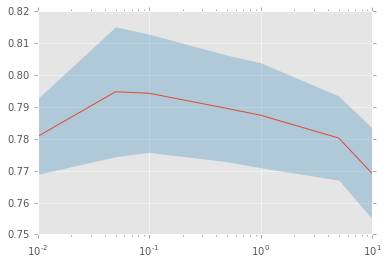

0.79476190476190478

In [14]:
estimator = LogisticRegression(random_state=0)
optimizer_zeros = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_zeros.fit(X_train_zeros, y_train)
plot_scores(optimizer_zeros)
optimizer_zeros.best_score_

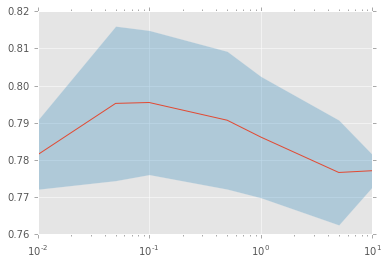

0.79547619047619045

In [15]:
optimizer_means = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_means.fit(X_train_means, y_train)
plot_scores(optimizer_means)
optimizer_means.best_score_

In [16]:
predictions_m = optimizer_means.best_estimator_.predict_proba(X_test_means)
roc_mean = roc_auc_score(y_test, predictions_m[:,1])
print "ROC-AUC for means: {}".format(roc_mean)

ROC-AUC for means: 0.887875533162


In [17]:
predictions_z = optimizer_zeros.best_estimator_.predict_proba(X_test_zeros)
roc_zero = roc_auc_score(y_test, predictions_z[:,1])
print "ROC-AUC for zeros: {}".format(roc_zero)

ROC-AUC for zeros: 0.884650269566


In [18]:
write_answer_1(roc_mean, roc_zero)

mean_roc_auc = (roc_mean+roc_zero)/2
with open("preprocessing_lr_answer1_mean.txt", "w") as fout:
    fout.write(str(mean_roc_auc))

## Масштабирование вещественных признаков

Попробуем улучшить качество классификации. Посмотрим на данные:

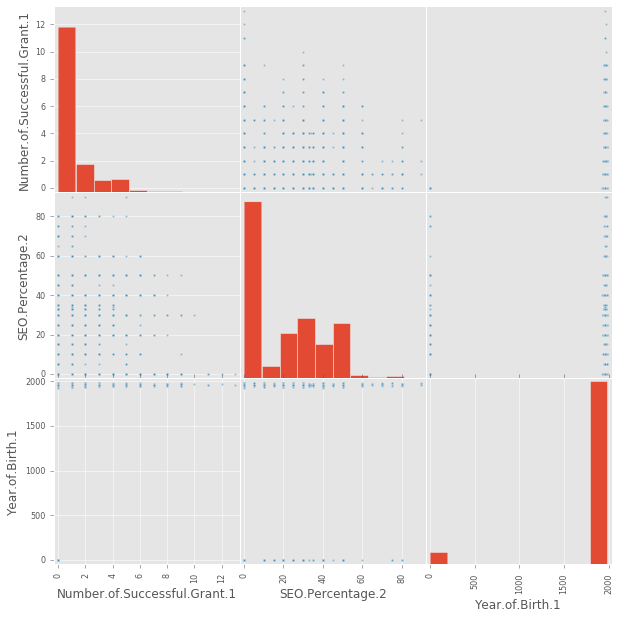

In [19]:
from pandas.tools.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, разные признаки очень сильно отличаются друг от друга по модулю значений (обратите внимание на диапазоны значений осей x и y). В случае обычной регрессии это никак не влияет на качество обучаемой модели, т.к. у меньших по модулю признаков будут большие веса, но при использовании регуляризации, которая штрафует модель за большие веса, регрессия, как правило, начинает работать хуже.

В таких случаях рекомендуется делать стандартизацию (масштабирование) признаков, чтобы они меньше отличались друг друга по модулю. При этом даже если итоговое качество модели на тесте уменьшается, это повышает её интерпретируемость, потому что новые веса имеют смысл "значимости" данного признака для итоговой классификации.

Стандартизация осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

## Задание 1.5. Масштабирование вещественных признаков

1. По аналогии с вызовом one-hot encoder примените масштабирование вещественных признаков для обучающих и тестовых выборок X_train_real_zeros и X_test_real_zeros, используя класс 

        StandardScaler
   
   и методы 

        StandardScaler.fit_transform(...)
        StandardScaler.transform(...)
2. Сохраните ответ в переменные X_train_real_scaled и X_test_real_scaled соответственно

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real_zeros)
X_test_real_scaled = scaler.transform(X_test_real_zeros)

## Сравнение признаковых пространств

Посмотрим на преобразованные данные:

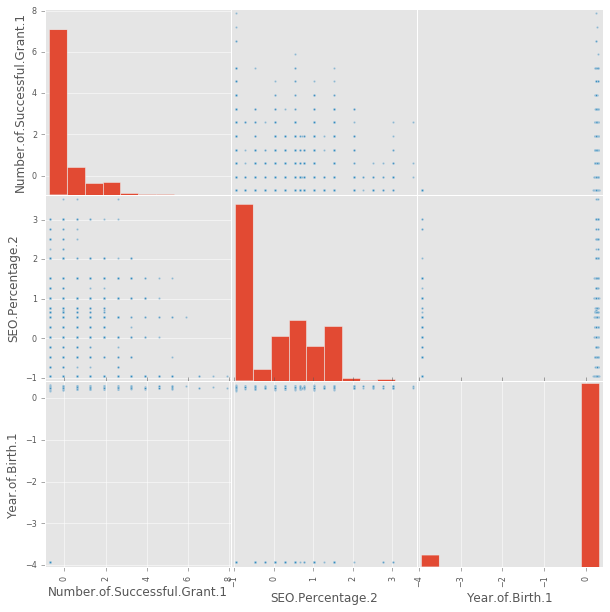

In [21]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

Как видно из графиков, мы не поменяли свойства признакового пространства: гистограммы распределений значений признаков и их диаграммы рассеяния выглядят так же, как и до нормировки, но при этом все значения теперь находятся примерно в одном диапазоне.

## Задание 2. Сравнение качества классификации до и после масштабирования вещественных признаков
1. Обучите ещё раз регрессию и гиперпараметры на новых признаках, объединив их с закодированными категориальными.
2. Проверьте, был ли найден оптимум accuracy по гиперпараметрам во время кросс-валидации.
3. Получите значение ROC AUC на тестовой выборке, сравните с лучшим результатом, полученными ранее.
4. Запишите полученный ответ в файл при помощи функции write_answer_2.

In [22]:
def write_answer_2(auc):
    with open("preprocessing_lr_answer2.txt", "w") as fout:
        fout.write(str(auc))
        
# place your code here

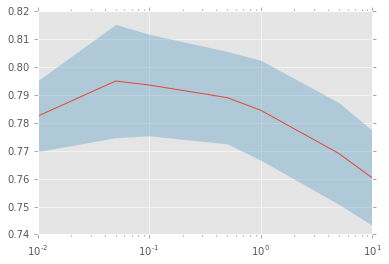

0.795
ROC-AUC for zeros: 0.885044379083


In [23]:
X_train_zeros_scaled = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_test_zeros_scaled = np.hstack((X_test_real_scaled, X_test_cat_oh))

estimator = LogisticRegression()
optimizer_zeros = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_zeros.fit(X_train_zeros_scaled, y_train)
plot_scores(optimizer_zeros)
print optimizer_zeros.best_score_

predictions_z_scaled = optimizer_zeros.best_estimator_.predict_proba(X_test_zeros_scaled)
roc_zero_scaled = roc_auc_score(y_test, predictions_z_scaled[:,1])
print "ROC-AUC for zeros: {}".format(roc_zero_scaled)

write_answer_2(roc_zero_scaled)

## Балансировка классов

Алгоритмы классификации могут быть очень чувствительны к несбалансированным классам. Рассмотрим пример с выборками, сэмплированными из двух гауссиан. Их матожидания и матрицы ковариации заданы так, что истинная разделяющая поверхность должна проходить параллельно оси x. Поместим в обучающую выборку 20 объектов, сэмплированных из 1-й гауссианы, и 10 объектов из 2-й. После этого обучим на них линейную регрессию, и построим на графиках объекты и области классификации.

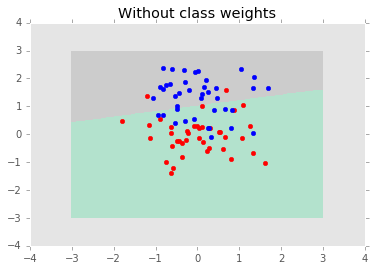

AUC: 0.906667


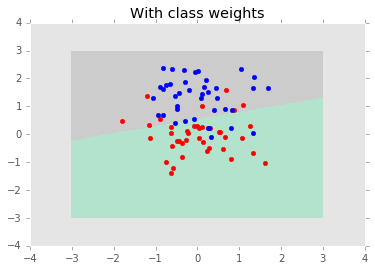

AUC: 0.895000


In [24]:
np.random.seed(0)
"""Сэмплируем данные из первой гауссианы"""
data_0 = np.random.multivariate_normal([0,0], [[0.5,0],[0,0.5]], size=40)
"""И из второй"""
data_1 = np.random.multivariate_normal([0,1], [[0.5,0],[0,0.5]], size=40)
"""На обучение берём 20 объектов из первого класса и 10 из второго"""
example_data_train = np.vstack([data_0[:20,:], data_1[:10,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((10))])
"""На тест - 20 из первого и 30 из второго"""
example_data_test = np.vstack([data_0[20:,:], data_1[10:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((30))])
"""Задаём координатную сетку, на которой будем вычислять область классификации"""
xx, yy = np.meshgrid(np.arange(-3, 3, 0.02), np.arange(-3, 3, 0.02))
"""Обучаем регрессию без балансировки по классам"""
optimizer = GridSearchCV(LogisticRegression(), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
"""Строим предсказания регрессии для сетки"""
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
"""Считаем AUC"""
auc_wo_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('Without class weights')
plt.show()
print('AUC: %f'%auc_wo_class_weights)
"""Для второй регрессии в LogisticRegression передаём параметр class_weight='balanced'"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_w_class_weights = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC: %f'%auc_w_class_weights)

Как видно, во втором случае классификатор находит разделяющую поверхность, которая ближе к истинной, т.е. меньше переобучается. Поэтому на сбалансированность классов в обучающей выборке всегда следует обращать внимание.

Посмотрим, сбалансированны ли классы в нашей обучающей выборке:

In [25]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2316
1884


Видно, что нет.

Исправить ситуацию можно разными способами, мы рассмотрим два:
- давать объектам миноритарного класса больший вес при обучении классификатора (рассмотрен в примере выше),
- досэмплировать объекты миноритарного класса, пока число объектов в обоих классах не сравняется.

## Задание 3. Балансировка классов
1. Обучите логистическую регрессию и гиперпараметры с балансировкой классов, используя веса (параметр class_weight='balanced' регрессии) на отмасштабированных выборках, полученных в предыдущем задании. Убедитесь, что вы нашли максимум accuracy по гиперпараметрам.
2. Получите метрику ROC AUC на тестовой выборке.
3. Сбалансируйте выборку, досэмплировав в неё объекты из меньшего класса. Для получения индексов объектов, которые требуется добавить в обучающую выборку, используйте следующую комбинацию вызовов функций:
        np.random.seed(0)
        indices_to_add = np.random.randint(...)
        X_train_to_add = X_train[y_train.as_matrix() == 1,:][indices_to_add,:]
   После этого добавьте эти объекты в начало или конец обучающей выборки. Дополните соответствующим образом вектор ответов.
4. Получите метрику ROC AUC на тестовой выборке, сравните с предыдущим результатом.
5. Внесите ответы в выходной файл при помощи функции write_asnwer_3, передав в неё сначала ROC AUC для балансировки весами, а потом для балансировки выборки вручную.

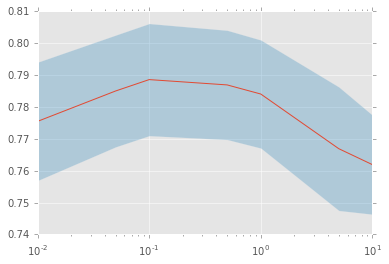

0.788571428571
ROC-AUC for balanced: 0.887185068137


In [26]:
estimator_balanced = LogisticRegression(class_weight='balanced' )
optimizer_balanced = GridSearchCV(estimator_balanced, param_grid, cv=cv)
optimizer_balanced.fit(X_train_zeros_scaled, y_train)
plot_scores(optimizer_balanced)
print optimizer_balanced.best_score_

predictions_balanced = optimizer_balanced.best_estimator_.predict_proba(X_test_zeros_scaled)
roc_auc_balanced = roc_auc_score(y_test, predictions_balanced[:,1])
print "ROC-AUC for balanced: {}".format(roc_auc_balanced)

In [27]:
def write_answer_3(auc_1, auc_2):
    answers = [auc_1, auc_2]
    with open("preprocessing_lr_answer3.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in answers]))
        
# place your code here

In [28]:
_0class = np.sum(y_train==0)
_1class = np.sum(y_train==1)
np.random.seed(0)
indices_to_add = np.random.randint(0, _1class, size = _0class - _1class)
X_train_to_add = X_train_zeros_scaled[y_train.as_matrix() == 1,:][indices_to_add,:]
X_train_extended = np.vstack([X_train_zeros_scaled, X_train_to_add])
y_train_extended = np.concatenate([y_train, np.ones(len(X_train_to_add))])

print(np.sum(y_train_extended==0))
print(np.sum(y_train_extended==1))

estimator_extended = LogisticRegression()
optimizer_extended = GridSearchCV(estimator_extended, param_grid, cv=cv)
optimizer_extended.fit(X_train_extended, y_train_extended)
print optimizer_extended.best_score_

predictions_extended = optimizer_extended.best_estimator_.predict_proba(X_test_zeros_scaled)
roc_auc_extended = roc_auc_score(y_test, predictions_extended[:,1])
print "ROC-AUC for extended: {}".format(roc_auc_extended)

write_answer_3(roc_auc_balanced, roc_auc_extended)
mean_roc_auc_3 = (roc_auc_balanced+roc_auc_extended)/2
with open("preprocessing_lr_answer3_mean.txt", "w") as fout:
    fout.write(str(mean_roc_auc_3))

2316
2316
0.805483592401
ROC-AUC for extended: 0.883265008643


## Стратификация выборок

Рассмотрим ещё раз пример с выборками из нормальных распределений. Посмотрим ещё раз на качество классификаторов, получаемое на тестовых выборках:

In [29]:
print('AUC ROC for classifier without weighted classes', auc_wo_class_weights)
print('AUC ROC for classifier with weighted classes: ', auc_w_class_weights)

('AUC ROC for classifier without weighted classes', 0.90666666666666662)
('AUC ROC for classifier with weighted classes: ', 0.89500000000000002)


Насколько эти цифры реально отражают качество работы алгоритма, если учесть, что тестовая выборка так же несбалансирована, как обучающая? 
Мы уже знаем, что алгоритм логистический регрессии чувствителен к балансировке классов в обучающей выборке, т.е. в данном случае на тесте он будет давать заведомо заниженные результаты. Метрика классификатора на тесте имела бы гораздо больший смысл, если бы объекты были разделы в выборках поровну: по 20 из каждого класса на обучени и на тесте. Переформируем выборки и подсчитаем новые ошибки:

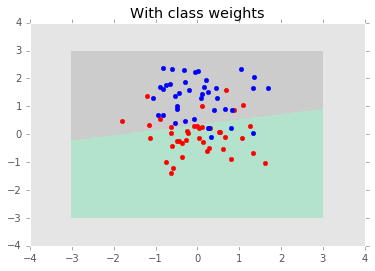

('AUC ROC for stratified samples: ', 0.91000000000000003)


In [30]:
"""Разделим данные по классам поровну между обучающей и тестовой выборками"""
example_data_train = np.vstack([data_0[:20,:], data_1[:20,:]])
example_labels_train = np.concatenate([np.zeros((20)), np.ones((20))])
example_data_test = np.vstack([data_0[20:,:], data_1[20:,:]])
example_labels_test = np.concatenate([np.zeros((20)), np.ones((20))])
"""Обучим классификатор"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train, example_labels_train)
Z = optimizer.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
auc_stratified = roc_auc_score(example_labels_test, optimizer.predict_proba(example_data_test)[:,1])
plt.title('With class weights')
plt.show()
print('AUC ROC for stratified samples: ', auc_stratified)

Как видно, после данной процедуры ответ классификатора изменился незначительно, а вот качество увеличилось. При этом, в зависимости от того, как вы разбили изначально данные на обучение и тест, после сбалансированного разделения выборок итоговая метрика на тесте может как увеличиться, так и уменьшиться, но доверять ей можно значительно больше, так как она построена с учётом специфики работы классификатора. Данный подход является частным случаем так называемого метода стратификации.

## Задание 4. Стратификация выборки

1. По аналогии с тем, как это было сделано в начале задания, разбейте выборки X_real_zeros и X_cat_oh на обучение и тест, передавая в функцию 
       train_test_split(...)
   дополнительный параметр 
       stratify=y
   Также обязательно передайте в функцию переменную random_state=0.
2. Выполните масштабирование новых вещественных выборок, обучите классификатор и его гиперпараметры при помощи метода кросс-валидации, делая поправку на несбалансированные классы при помощи весов. Убедитесь в том, что нашли оптимум accuracy по гиперпараметрам.
3. Оцените качество классификатора метрике AUC ROC на тестовой выборке.
4. Полученный ответ передайте функции write_answer_4

In [31]:
def write_answer_4(auc):
    with open("preprocessing_lr_answer4.txt", "w") as fout:
        fout.write(str(auc))
        
# place your code here

In [32]:
(X_train_real_zeros_strat, 
 X_test_real_zeros_strat, 
 y_train_strat, y_test_strat) = train_test_split(X_real_zeros, y,
                                                 test_size=0.3, 
                                     stratify=y,
                                     random_state=0)
(X_train_cat_oh_strat,
 X_test_cat_oh_strat) = train_test_split(X_cat_oh, 
                                         test_size=0.3, 
                                   stratify=y,
                                   random_state=0)

scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real_zeros_strat)
X_test_real_scaled = scaler.transform(X_test_real_zeros_strat)

X_train_zeros_strat = np.hstack((X_train_real_scaled, X_train_cat_oh_strat))
X_test_zeros_strat = np.hstack((X_test_real_scaled, X_test_cat_oh_strat))

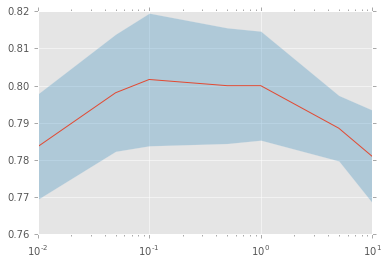

0.801666666667


In [33]:
optimizer_strat = GridSearchCV(LogisticRegression(class_weight='balanced' ), param_grid, cv=cv)
optimizer_strat.fit(X_train_zeros_strat, y_train_strat)
plot_scores(optimizer_strat)
print optimizer_strat.best_score_

In [34]:
predictions_strat = optimizer_strat.best_estimator_.predict_proba(X_test_zeros_strat)
roc_auc_strat = roc_auc_score(y_test_strat, predictions_strat[:,1])
print "ROC-AUC for stratified: {}".format(roc_auc_strat)
write_answer_4(roc_auc_strat)

ROC-AUC for stratified: 0.87934871305


Теперь вы разобрались с основными этапами предобработки данных для линейных классификаторов.
Напомним основные этапы:
- обработка пропусков
- перекодирование категориальных признаков
- стратификация
- балансировка классов
- масштабирование

Эти действия с данными рекомендуется проводить при каждом использовании линейных методов, да и многих других.

## Трансформация признаков

Существует достаточно много различных способов трансформации признаков, которые позволяют при помощи линейных методов получать более сложные разделяющие поверхности. Самый простой — полиномиальное преобразование признаков. Его идея заключается в том, что помимо самих признаков вы дополнительно включаете набор все полиномы степени $p$, которые можно из них построить. Для случая $p=2$ преобразование выглядит следующим образом:

$$ \phi(x_i) = [x_{i,1}^2, ..., x_{i,D}^2, x_{i,1}x_{i,2}, ..., x_{i,D}, x_{i,D-1}, x_{i,1}, ..., x_{i,D}, 1] $$

Рассмотрим принцип работы данных признаков на данных, сэмплированных их гауссиан:

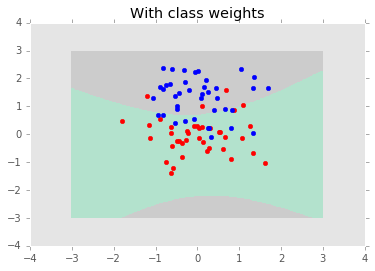

In [35]:
from sklearn.preprocessing import PolynomialFeatures

"""Инициализируем класс, который выполняет преобразование"""
transform = PolynomialFeatures(2)
"""Обучаем преобразование на обучающей выборке, применяем его к тестовой"""
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
"""Обращаем внимание на параметр fit_intercept=False"""
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('With class weights')
plt.show()

Видно, что добавление полиномов от признаков позволяет строить нелинейные разделяющие поверхности, которые могут лучше подстраиваться под данные и находить более сложные зависимости. 

С другой стороны, с увеличением степени $p$ из-за быстрого роста числа признаков модель будет быстрее переобучаться. Число признаков в новой модели:

In [36]:
print(example_data_train_poly.shape)

(40, 6)


Рассмотрим пример с $p=11$:

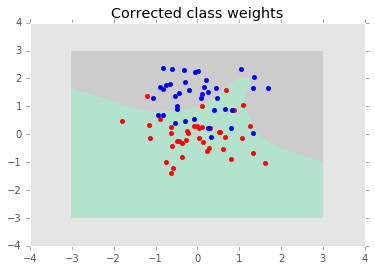

In [37]:
transform = PolynomialFeatures(11)
example_data_train_poly = transform.fit_transform(example_data_train)
example_data_test_poly = transform.transform(example_data_test)
optimizer = GridSearchCV(LogisticRegression(class_weight='balanced', fit_intercept=False), param_grid, cv=cv, n_jobs=-1)
optimizer.fit(example_data_train_poly, example_labels_train)
Z = optimizer.predict(transform.transform(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
plt.scatter(data_0[:,0], data_0[:,1], color='red')
plt.scatter(data_1[:,0], data_1[:,1], color='blue')
plt.title('Corrected class weights')
plt.show()

Очень плохо! Количество признаков здесь:

In [38]:
print(example_data_train_poly.shape)

(40, 78)


Очень много!

## Задание 5. Трансформация вещественных признаков

1. По аналогии с примером добавьте в модель квадраты вещественных признаков.
2. Постройте логистическую регрессию на новых данных, одновременно подобрав оптимальные гиперпараметры. Обращаем внимание, что в среди квадратов признаков уже присутствует столбец, все значения которого равны 1, поэтому обучать дополнительно значение $b$ не нужно, его функцию выполняет один из весов $w$. В связи с этим, во избежание линейной зависимости признаков, в вызов класса логистической регрессии требуется передавать параметр fit_intercept=False. Для обучения используйте стратифицированные выборки с балансировкой классов при помощи весов, преобразованные признаки требуется заново отмасштабировать.
3. Получите AUC ROC на тесте и сравните данный результат с использованием обычных признаков.
4. Передайте полученный ответ в функцию write_answer_5.

In [39]:
def write_answer_5(auc):
    with open("preprocessing_lr_answer5.txt", "w") as fout:
        fout.write(str(auc))
        
# place your code here

(X_train_real_zeros_strat, 
 X_test_real_zeros_strat, 
 y_train_strat, y_test_strat) = train_test_split(X_real_zeros, y,
                                                 test_size=0.3, 
                                     stratify=y,
                                     random_state=0)
(X_train_cat_oh_strat,
 X_test_cat_oh_strat) = train_test_split(X_cat_oh, 
                                         test_size=0.3, 
                                   stratify=y,
                                   random_state=0)

In [40]:
transform = PolynomialFeatures(2)
X_train_real_poly = transform.fit_transform(X_train_real_zeros_strat)
X_test_real_poly = transform.transform(X_test_real_zeros_strat)

scaler = StandardScaler()
X_train_real_poly_scaled = scaler.fit_transform(X_train_real_poly)
X_test_real_poly_scaled = scaler.transform(X_test_real_poly)

X_train_zeros_poly = np.hstack((X_train_real_poly_scaled, X_train_cat_oh_strat))
X_test_zeros_poly = np.hstack((X_test_real_poly_scaled, X_test_cat_oh_strat))

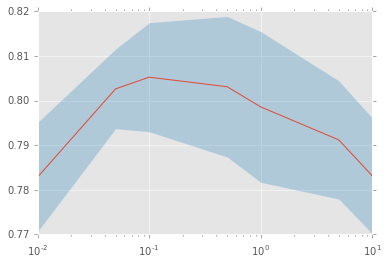

0.805238095238


In [41]:
optimizer_poly = GridSearchCV(LogisticRegression(class_weight='balanced' ), param_grid, cv=cv)
optimizer_poly.fit(X_train_zeros_poly, y_train_strat)
plot_scores(optimizer_poly)
print optimizer_poly.best_score_

In [42]:
predictions_poly = optimizer_poly.best_estimator_.predict_proba(X_test_zeros_poly)
roc_auc_poly = roc_auc_score(y_test_strat, predictions_poly[:,1])
print "ROC-AUC for polynomial: {}".format(roc_auc_poly)
write_answer_5(roc_auc_poly)

ROC-AUC for polynomial: 0.887000009951


## Lasso
C логистической регрессией можно использовать и регуляризатор $L_1$ (Lasso), который будет приводить к отбору признаков. Давайте попробуем применить $L_1$-регуляцию к исходным признакам и проинтерпретировать полученные результаты (применение отбора признаков к полиномиальным так же можно успешно применять, но в нём уже будет отсутствовать компонента интерпретации, так как интерпретировать полиномы от признаков может быть довольно сложно). Для вызова логистической регрессии с $L_1$-регуляризацией достаточно передать параметр penalty='l1' в инициализацию класса.

## Задание 6. Отбор признаков при помощи Lasso
1. Обучите регрессию Lasso на стратифицированных отмасштабированных выборках, используя балансировку классов при помощи весов.
2. Получите ROC AUC регрессии, сравните его с предыдущими результатами.
3. Найдите номера вещественных признаков, которые имеют нулевые веса в итоговой модели.
4. Передайте их список функции write_answer_6.

In [43]:
def write_answer_6(features):
    with open("preprocessing_lr_answer6.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in features]))
        
# place your code here

X_train_zeros_strat = np.hstack((X_train_real_scaled, X_train_cat_oh_strat))
X_test_zeros_strat = np.hstack((X_test_real_scaled, X_test_cat_oh_strat))

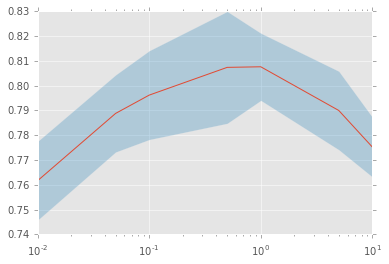

0.807619047619
ROC-AUC for lasso: 0.876475278512


In [45]:
optimizer_lasso = GridSearchCV(LogisticRegression(class_weight='balanced', penalty='l1' ), param_grid, cv=cv)
optimizer_lasso.fit(X_train_zeros_strat, y_train_strat)
plot_scores(optimizer_lasso)
print optimizer_lasso.best_score_
predictions_lasso = optimizer_lasso.best_estimator_.predict_proba(X_test_zeros_strat)
roc_auc_lasso = roc_auc_score(y_test_strat, predictions_lasso[:,1])
print "ROC-AUC for lasso: {}".format(roc_auc_lasso)

In [62]:
print len(numeric_cols)
weights = optimizer_lasso.best_estimator_.coef_[:,:len(numeric_cols)]
print weights.shape
for i, f in enumerate(numeric_cols):
    print "%s: %f" % (f, weights[0, i])

13
(1, 13)
RFCD.Percentage.1: 0.014065
RFCD.Percentage.2: 0.042193
RFCD.Percentage.3: -0.088239
RFCD.Percentage.4: -0.067629
RFCD.Percentage.5: 0.000000
SEO.Percentage.1: -0.004004
SEO.Percentage.2: 0.000000
SEO.Percentage.3: 0.000000
SEO.Percentage.4: 0.024806
SEO.Percentage.5: -0.007477
Year.of.Birth.1: 0.232732
Number.of.Successful.Grant.1: 1.065076
Number.of.Unsuccessful.Grant.1: -1.433678


In [83]:
zero_features = [(i, numeric_cols[i], w) for i, w in enumerate(weights[0]) if abs(w) <= 1e-3]
print zero_features
print [x[0] for x in zero_features]
write_answer_6([x[0] for x in zero_features])

[(4, 'RFCD.Percentage.5', 0.0), (6, 'SEO.Percentage.2', 0.0), (7, 'SEO.Percentage.3', 0.0)]
[4, 6, 7]
